In [1]:
import pandas as pd
from joblib import dump, load
import matplotlib.pyplot as plt

In [2]:
from utils.dangerous_driving import DangerousDrivingDetection
from utils.driving_event import DrivingEventDetection
from utils.preprocessing import kalman_filter
from utils.plotting import plot_difference_line, plot_silhouette_scores_of_clusters, print_confusion_matrix
from utils.load import load_features_group, load_label_df, load_model

###### Constants

In [3]:
N_CLUSTERS = 3
LABEL_PATH = "./safety/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv"
FEATURES_PATHS = ["./safety/features/part-0000{}-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv".format(i) for i in range(10)]
WINDOW_SIZE = 3
URBAN_SPEED_LIMIT_IN_MS = 13.8889

###### Datas

In [4]:
dtypes_dict = {'bookingID': str}
label = load_label_df(LABEL_PATH)
features = load_features_group(FEATURES_PATHS)

# Driving Event Detection

###### Data

In [5]:
longest_trip_id = features.size().sort_values(ascending=False).head(1).index.values[0]
driving_event_features = features.get_group(longest_trip_id)

In [6]:
driving_event = DrivingEventDetection(driving_event_features)

In [7]:
driving_event.data.head(10)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
688080,438086664371,4.0,351.0,0.339977,10.928333,1.784877,0.011484,0.070017,-0.096468,0.0,7.340000
1554664,438086664371,4.0,351.0,-0.873884,9.346964,2.134431,0.329745,0.332689,-0.191152,1.0,9.540000
1038426,438086664371,4.0,352.0,0.902614,9.793482,2.266112,-0.014172,0.005877,0.015321,2.0,9.700000
746317,438086664371,4.0,352.0,-0.244209,9.490616,0.541090,-0.038607,0.007098,0.002492,3.0,9.440000
77421,438086664371,4.0,350.0,-0.547075,9.014170,-3.253720,0.074403,-0.085753,0.128331,4.0,9.420000
992307,438086664371,5.0,350.0,-0.480037,8.300697,-1.753753,-0.012339,-0.033219,0.021429,5.0,8.990000
400858,438086664371,5.0,350.0,1.100136,9.385271,-0.304064,0.113499,-0.099803,0.129552,6.0,10.490000
624754,438086664371,5.0,349.0,-0.507571,10.576386,4.575319,-0.126571,0.020537,0.031203,7.0,11.090000
1336458,438086664371,5.0,347.0,0.772130,10.296265,4.357447,-0.022113,0.040696,-0.054318,8.0,10.290000
300509,438086664371,5.0,346.0,1.626860,10.843340,6.062118,-0.482095,-0.354534,0.230956,9.0,9.139999


### Feature Selection

Since longitudinal and lateral motion of the vehicle are determined by Y axis linear acceleration and Z axis angular acceleration, we will use those features

In [8]:
driving_event.set_data(driving_event.data.loc[:, ["acceleration_y", "gyro_z", "second"]])

### Pre Processing

We'll use kalman filter to reduce noise in the data

In [9]:
seconds = driving_event.data['second'].copy()
acc_y_before_filter = driving_event.data["acceleration_y"].copy()
gyro_z_before_filter = driving_event.data["gyro_z"].copy()

In [10]:
driving_event.pre_process("acceleration_y", lambda x: kalman_filter(x, "acceleration_y"))
driving_event.pre_process("gyro_z", lambda x: kalman_filter(x, "gyro_z"))

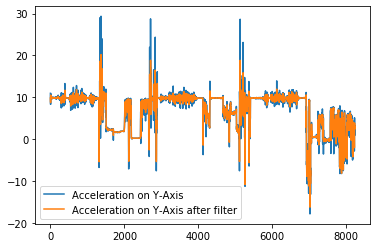

In [11]:
plot_difference_line(seconds, [acc_y_before_filter, driving_event.data['acceleration_y']], 
                     ["Acceleration on Y-Axis", "Acceleration on Y-Axis after filter"])

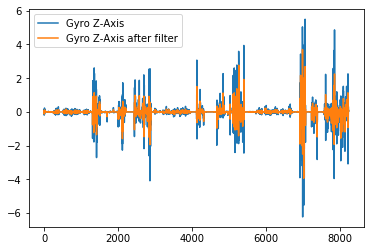

In [12]:
plot_difference_line(seconds, [gyro_z_before_filter, driving_event.data['gyro_z']], 
                     ["Gyro Z-Axis", "Gyro Z-Axis after filter"])

### Feature Extraction

##### Sliding Window

Most events that happen during driving (speed control, steady driving, hard turn, etc) take time more than 1 second. However, the dataset only give us the acceleration per 1 second. That's why we need to fetch data every N seconds and summarize it. The N here is 3 seconds

The statistical feature that will be used per window is variance. Mean, variance, and IQR have been tested and combined with each other and variance has the best silhouette score during clustering.

In [13]:
cluster_data = driving_event.load_clustering_features(["acceleration_y", "gyro_z"]).dropna()

In [14]:
driving_event.set_data(cluster_data)

### Clustering

##### Scaling with Standard Scaler

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
driving_event.scale_data(StandardScaler())

#### Training

I choose 3 clusters since it has the biggest silhouette score than others

In [17]:
%matplotlib inline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

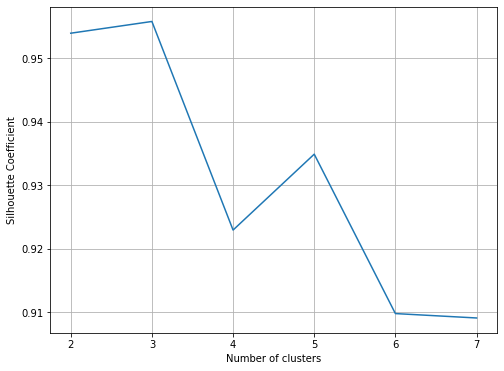

In [18]:
try_range = range(2, 8)
plot_silhouette_scores_of_clusters(driving_event.data, cluster_range=try_range, figsize=(8, 6))

According to this plot, 3 clusters will give the best clustering result (measured by silhouette score)

In [19]:
try:
    km = load('models/k_means.joblib')
    print("K-Means Model loaded from joblib file")
except FileNotFoundError:
    km = KMeans(n_clusters=N_CLUSTERS, random_state=1, tol=1e-8)
    km = driving_event.train(km)
    dump(km, 'models/k_means.joblib')
    print("K-Means Model instantiated, trained, and saved")

K-Means Model loaded from joblib file


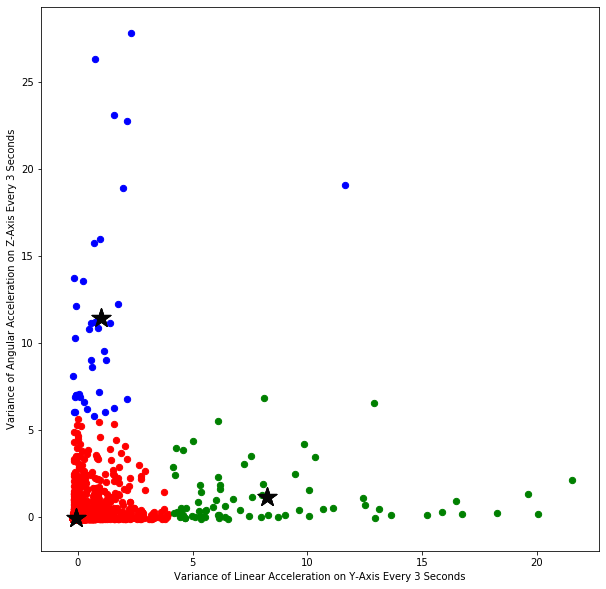

In [20]:
colors = ['r', 'g', 'b']
plt.figure(figsize=(10,10))
k = N_CLUSTERS
x_arr = driving_event.data
labels = km.labels_
centroids = km.cluster_centers_
for i in range(k):
    points = np.array([x_arr[j] for j in range(len(driving_event.data)) if labels[j] == i])
    plt.scatter(points[:, 0], points[:, 1], s=40, c=colors[i])
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=400,
                c='#050505')

plt.xlabel("Variance of Linear Acceleration on Y-Axis Every 3 Seconds")
plt.ylabel("Variance of Angular Acceleration on Z-Axis Every 3 Seconds")
plt.show()

# Dangerous Driving Detection

We'll use the KMeans model to detect events that occured in any trips. These events will be counted and the number of the events will be fed to the classifier. The steps for these task are pretty much the same as the driving event detection, except that we're working with groups now rather than a dataframe.

In [21]:
danger_driving = DangerousDrivingDetection(features)

##### Feature Extraction

We'll use the same method as the previous one, which is sliding window. We'll use the data from the sliding window and predict the event of every window using the KMeans model. Then we'll count every event. 

We'll also count how many times the driver passes the urban speed limit (stated by WHO). We'll also use sliding window with size of 10 seconds. We'll calculate the mean of every window and check whether it passes the speed limit or not. We'll count how many windows pass the speed limit.

In [22]:
classification_features = danger_driving.load_classification_features(k_means=km)

In [23]:
classification_features.merge(label, on="bookingID").head(10)

,bookingID,0,1,2,label
0,0,983,16,3,0
1,1,832,13,4,1
2,10,367,4,2,0
3,1005022347266,822,10,6,1
4,1005022347267,722,8,8,1
5,1005022347268,417,6,3,0
6,1005022347269,1573,14,6,0
7,1005022347271,412,3,3,0
8,1005022347275,611,12,5,0
9,1005022347277,1031,9,8,0


In [24]:
danger_driving.set_data(classification_features)

In [25]:
danger_driving.merge_label_to_data(label, on="bookingID")
danger_driving.drop_column("bookingID")

###### Training

We'll use Random Forest Classifier

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [27]:
x, y = danger_driving.split_feature_and_label("label")

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [29]:
mms = MinMaxScaler()
x_train = mms.fit_transform(x_train)
x_test = mms.fit_transform(x_test)

In [30]:
from sklearn.ensemble import RandomForestClassifier    
rf = RandomForestClassifier(max_depth=6, n_estimators=100, random_state=42, max_features='sqrt')
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

###### Evaluation

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score
import seaborn as sns

In [32]:
y_pred = rf.predict(x_test)
probs = rf.predict_proba(x_test)[:, 1]

In [33]:
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Recall Score:", recall_score(y_test, y_pred))
print("Precision Score:", precision_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, probs))

Accuracy Score: 0.7526666666666667
Recall Score: 0.01000667111407605
Precision Score: 1.0
F1 Score: 0.019815059445178335
AUC: 0.6316702433185479


In [34]:
cm = confusion_matrix(y_test, y_pred)

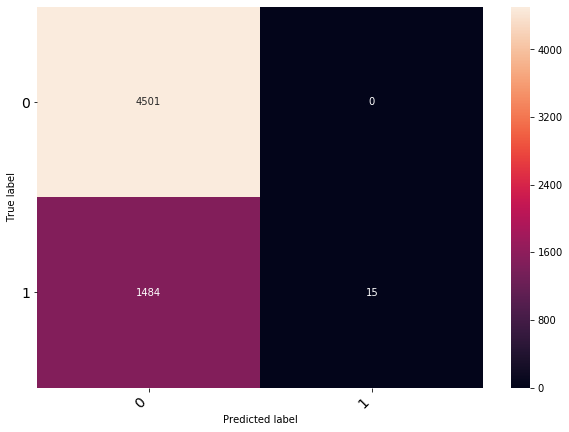

In [35]:
cm = print_confusion_matrix(cm, [0, 1])

In [36]:
from sklearn.metrics import roc_curve

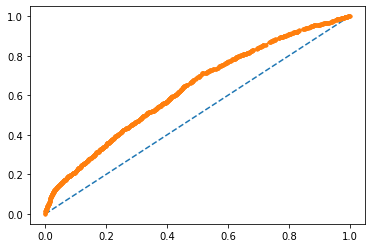

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()